In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal

import sys
sys.path.insert(0, '..')
import specsens as ss

---- Simulation parameter ----
Generations:    300
Iterations:     300
Total Iters:    90000
Signal power:   0.00 dB
Noise power:    15.00 dB
Noise uncert.:  5.00 dB
SNR:            -15.00 dB
Signal length:  0.001024 sec
Signal samples: 1024
Num. of bands:  4
Band to detect: 2
---- Simulation stats theory ----
Prob false alarm 0.1000
Prob detection   0.7375
Threshold        8750.2440
---- Running simulation ----
Noise act 5.456841215866376
Noise est 5.311048008100107
   infs left at  0.00%
Noise act 11.008194965043241
Noise est 11.114790668603394
119.46s left at  0.33%
Noise act 14.076393897407687
Noise est 14.103406708445027
192.82s left at  0.67%
Noise act 15.55101645862813
Noise est 15.4615727984332
142.31s left at  1.00%
Noise act 16.217596881063063
Noise est 16.202583438362584
146.98s left at  1.33%
Noise act 20.108083216783108
Noise est 20.118300583893998
123.45s left at  1.67%
Noise act 14.699644275224353
Noise est 14.681366101829136
120.20s left at  2.00%
Noise act 4.9224956157

Noise act 16.839368232022707
Noise est 16.82480175995527
 79.36s left at 32.33%
Noise act 7.820035250214559
Noise est 7.6076067446105355
 75.96s left at 32.67%
Noise act 7.18919165244427
Noise est 7.256313637583618
 75.28s left at 33.00%
Noise act 16.094230180073357
Noise est 16.187963671139144
 76.95s left at 33.33%
Noise act 8.148550438645639
Noise est 8.083095966818503
 76.18s left at 33.67%
Noise act 16.476918657578935
Noise est 16.486108714684928
 74.45s left at 34.00%
Noise act 18.765477984456563
Noise est 18.762462370137847
 74.13s left at 34.33%
Noise act 2.883581526032355
Noise est 2.8349346900908956
 73.53s left at 34.67%
Noise act 11.63916616988639
Noise est 11.536133665317184
 74.77s left at 35.00%
Noise act 16.081672711355942
Noise est 16.083395065119166
 72.94s left at 35.33%
Noise act 13.47853532863033
Noise est 13.401766918321723
 72.20s left at 35.67%
Noise act 14.477761911906692
Noise est 14.528146576504955
 71.77s left at 36.00%
Noise act 17.830371440042747
Noise est

Noise act 11.643088189255788
Noise est 11.789175206333848
 38.60s left at 66.67%
Noise act 14.927348390394156
Noise est 14.901016607306394
 49.00s left at 67.00%
Noise act 13.821440924956242
Noise est 13.899182942608032
 46.22s left at 67.33%
Noise act 10.267723147296973
Noise est 10.302304280905695
 45.66s left at 67.67%
Noise act 6.979967911655724
Noise est 6.906472379181956
 37.75s left at 68.00%
Noise act 23.95770270169542
Noise est 24.076864715687126
 38.07s left at 68.33%
Noise act 11.558686723582673
Noise est 11.508115210571466
 35.68s left at 68.67%
Noise act 17.908723064001947
Noise est 17.782021764763094
 36.19s left at 69.00%
Noise act 18.895451677947516
Noise est 18.78104540366412
 35.85s left at 69.33%
Noise act 13.106400141191852
Noise est 13.073049018641353
 36.30s left at 69.67%
Noise act 12.668777377444018
Noise est 12.696893582004218
 36.08s left at 70.00%
Noise act 27.362704346621552
Noise est 27.43032864132088
 33.95s left at 70.33%
Noise act 14.538300153973868
Nois

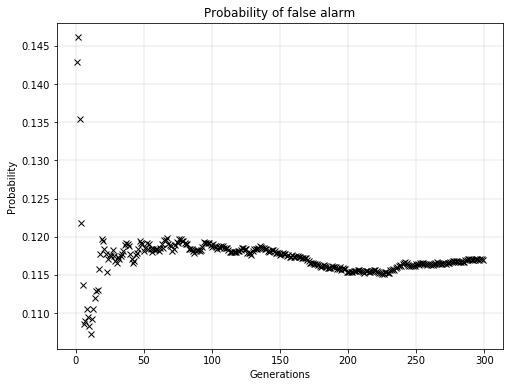

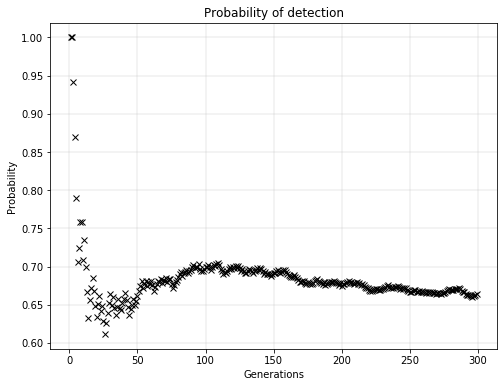

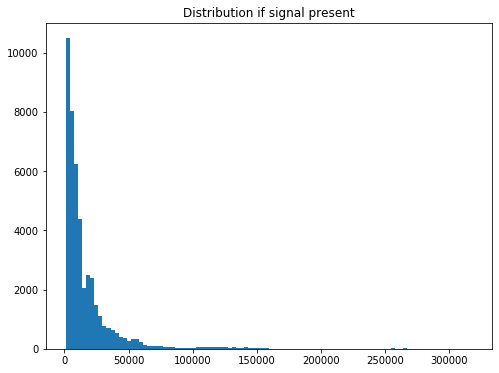

Sig Mean=17237.203, Standard Deviation=25267.236


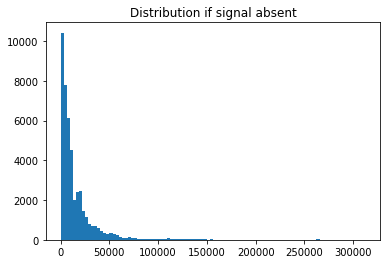

Noise Mean=16685.207, Standard Deviation=26422.902


In [12]:
def sim_wide(gens=100,
             itrs=100,
             f_sample=1e6,
             signal_strength=0.,
             noise_strength=0.,
             length_sec=None,
             num_samples=None,
             theo_pfa=0.1,
             threshold=None,
             noise_un=0.,
             bands=1,
             band_to_detect=0,
             nfft=1024):

    # Check and calculate length, in seconds and number of samples
    if num_samples is not None:
        assert num_samples > 0., 'num_samples must be greater than 0'
        length_sec = num_samples / f_sample
    elif length_sec is not None:
        assert length_sec > 0., 'length_sec must be greater than 0'
        length_sec = length_sec
        num_samples = int(f_sample * length_sec)
    else:
        assert False, 'either num_samples or length_sec needed'

    # Calculate threshold
    if threshold is None:
        threshold = ss.chi2_stats.get_thr(noise_power=noise_strength,
                                          pfa=theo_pfa,
                                          n=num_samples // bands,
                                          dB=True)

    print('---- Simulation parameter ----')
    print('Generations:    %d' % (gens))
    print('Iterations:     %d' % (itrs))
    print('Total Iters:    %d' % (gens * itrs))
    print('Signal power:   %.2f dB' % (signal_strength))
    print('Noise power:    %.2f dB' % (noise_strength))
    print('Noise uncert.:  %.2f dB' % (noise_un))
    print('SNR:            %.2f dB' % (signal_strength - noise_strength))
    print('Signal length:  %.6f sec' % (length_sec))
    print('Signal samples: %d' % (num_samples))
    print('Num. of bands:  %d' % (bands))
    print('Band to detect: %d' % (band_to_detect))

    theo_pd = ss.chi2_stats.get_pd(noise_strength,
                                   signal_strength,
                                   threshold,
                                   num_samples // bands,
                                   dB=True,
                                   bands=bands)

    print('---- Simulation stats theory ----')
    print('Prob false alarm %.4f' % (theo_pfa))
    print('Prob detection   %.4f' % (theo_pd))
    print('Threshold        %.4f' % (threshold))

    print('---- Running simulation ----')

    pfas = np.array([])  # Probability of false alarm list
    pds = np.array([])  # Probability of detection list
    en_sig = np.array([])  # Signal energy result list
    en_noise = np.array([])  # Noise energy result list
    current_time = None

    # Create new signal objects
    wm = ss.WirelessMicrophone(f_sample=f_sample, t_sec=length_sec)
    wgn = ss.WhiteGaussianNoise(f_sample=f_sample, t_sec=length_sec)

    # Outer generations loop
    for i in range(gens):

        # Calculate noise with uncertainty
        act_noise = np.random.normal(noise_strength, noise_un)
        
        # Array for noise estimation
        noise_est_list = np.array([])
        
        # Run itertations and store results in result array
        result = np.array([])
        for j in range(itrs):
            
            if np.size(noise_est_list) == 0:
                smooth_noise_est = act_noise
            else:    
                smooth_noise_est = np.mean(noise_est_list)
#                 smooth_noise_est = noise_est_list[0]
            
            threshold = ss.chi2_stats.get_thr(noise_power=smooth_noise_est,
                                          pfa=theo_pfa,
                                          n=num_samples // bands,
                                          dB=True)
            
            result_tmp, en, noise_est = iteration(wm, wgn, signal_strength,
                                                  act_noise, threshold,
                                                  f_sample, nfft, bands,
                                                  band_to_detect, theo_pfa,
                                                  num_samples)
            
            result = np.append(result, result_tmp)
            if result_tmp == 1 or result_tmp == 2:
                en_sig = np.append(en_sig, en)
            else:
                en_noise = np.append(en_noise, en)
                
            if np.size(noise_est_list) == 10:
                noise_est_list = np.delete(noise_est_list, 0)
            noise_est_list = np.append(noise_est_list, noise_est)
        
        print('Noise act', act_noise)
        print('Noise est', np.mean(noise_est_list))

        # Convert to numpy array
        result = np.asarray(result)

        # Calculate statistics and store in arrays
        pfa_tmp = np.sum(result == 3) / (np.sum(result == 3) +
                                         np.sum(result == 4))
        pd_tmp = np.sum(result == 1) / (np.sum(result == 1) +
                                        np.sum(result == 2))
        pfas = np.append(pfas, pfa_tmp)
        pds = np.append(pds, pd_tmp)

        # Print simulation progress
        rem, percent, current_time = ss.util_sim.runtime_stats(
            current_time, gens, i)
        print('%6.2fs left at %5.2f%%' % (rem, percent))

    # Compute stats from lists
    pfa = np.sum(pfas) / gens
    pd = np.sum(pds) / gens

    print('---- Simulation stats ----')
    print('Prob false alarm theory %.4f' % (theo_pfa))
    print('Prob false alarm sim    %.4f' % (pfa))
    print('Prob detection theory   %.4f' % (theo_pd))
    print('Prob detection sim      %.4f' % (pd))

    ss.util_sim.print_convergence(gens, pfas, pds)
    ss.util_sim.print_distibution(en_sig, en_noise)
    return pfa, pd


def iteration(wm,
              wgn,
              signal_strength,
              noise_strength,
              threshold,
              f_sample=1.e6,
              nfft=1024,
              bands=1,
              band_to_detect=0,
              theo_pfa=0.,
              num_samples=1024):

    # Generate signal, center frequency does not matter with single band ED
    sig = wm.get_soft(f_center=1e5, power=signal_strength, dB=True)

    # Generate noise
    noise = wgn.get_signal(power=noise_strength, dB=True)

    # Randomly decide whether signal should be present
    sig_present = bool(np.random.randint(2))
    if sig_present:
        both = sig + noise
    else:
        both = noise

    # Classic (single band) energy detector
    # eng = ss.EnergyDetector.get(both)

    # Mutliband stft based energy detector
    sft = ss.Stft(n=nfft, window='box')
    f, psd = sft.stft(sig=both, f_sample=f_sample, normalized=False, dB=False)
    edf = ss.FreqEnergyDetector(num_bands=bands,
                                f_sample=1e6,
                                fft_len=nfft,
                                freqs=f)
    eng = edf.detect(psd)[band_to_detect]

    # Estimate noise from band with only noise
    noise_pow = np.sum(psd[0:nfft // bands])
    noise_pow /= (nfft // bands)
    noise_pow = 10. * np.log10(noise_pow)
    #     print(noise_pow)
    
#     threshold = ss.chi2_stats.get_thr(noise_power=noise_strength,
#                                       pfa=0.1,
#                                       n=num_samples // bands,
#                                       dB=True)
    #     print(threshold)

    # Threshold
    sig_detected = eng > threshold

    # Log signal and detection outcome
    if sig_present and sig_detected:
        return 1, eng, noise_pow
    elif sig_present and not sig_detected:
        return 2, eng, noise_pow
    elif not sig_present and sig_detected:
        return 3, eng, noise_pow
    else:
        return 4, eng, noise_pow


# Wide band energy detector simulation
length = 1024
_ = sim_wide(
    gens=300,
    itrs=300,
    f_sample=1e6,  # in Hz
    signal_strength=0.0,  # in dB
    noise_strength=15.0,  # in dB
    num_samples=length,  # in seconds
    theo_pfa=0.1,  # probability of false alarm
    noise_un=5.0,  # standard deviation of the noise normal distribution
    bands=4,  # number of bands
    band_to_detect=2,  # which band to detect in
    nfft=length)  # length of fft

In [19]:
n_new = (1024 * 1024 * 10) / (1024 + 1024 * 10)
n_new = int(n_new)
n_new

ss.chi2_stats.get_pfa(15, 8750.2440, n_new // 4, dB=True)

0.0026608216904370208

In [28]:
ss.chi2_stats.get_pd(15,
                     0,
                     8750.2440,
                     1014 // 4,
                     dB=True,
                     bands=4)

0.6723880448168347